### Introdução

#### Neste notebook queremos verificar a influência de algumas variáveis como peso, localização, categoria do produto no preço do frete e posteriormente, criar um modelo de machine learning que consiga prever o valor do frete baseado nesses parâmetros.

### Importando bibliotecas e datasets

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [88]:
produto = pd.read_csv('olist_products_dataset.csv')
frete = pd.read_csv('olist_order_items_dataset.csv')
cliente = pd.read_csv('olist_customers_dataset.csv')
geolocation =pd.read_csv('olist_geolocation_dataset.csv')
seller = pd.read_csv('olist_sellers_dataset.csv')
order = pd.read_csv('olist_orders_dataset.csv')

In [89]:
produto.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [90]:
frete.head()
frete.shape

(112650, 7)

In [91]:
cliente.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [92]:
geolocation.head()
geolocation.shape

(1000163, 5)

In [93]:
lat = geolocation.groupby('geolocation_zip_code_prefix').geolocation_lat.median().sort_index().values
lon = geolocation.groupby('geolocation_zip_code_prefix').geolocation_lng.median().sort_index().values
print(len(lat), len(lon))

19015 19015


In [94]:
ceps = geolocation.drop(columns=['geolocation_lat','geolocation_lng'])

In [95]:
ceps['geolocation_city'] = ceps.geolocation_city.apply(lambda x: x.replace('ã','a').replace('â','a').replace('á','a').replace('é','e').replace('ç','c').replace('í','i').replace('ê','e').replace('õ','o').replace('ó','o').replace('ú','u').replace("'","").replace('ô','o'))

In [96]:
# remove duplicadas dos zip codes e mantem apenas o primeiro valor
ceps = ceps.sort_values('geolocation_zip_code_prefix').drop_duplicates(subset='geolocation_zip_code_prefix', keep='first').reset_index(drop=True)

In [97]:
ceps['latitude'] = lat
ceps['longitude'] = lon
ceps

,geolocation_zip_code_prefix,geolocation_city,geolocation_state,latitude,longitude
0,1001,sao paulo,SP,-23.550381,-46.634027
1,1002,sao paulo,SP,-23.548551,-46.635072
2,1003,sao paulo,SP,-23.548977,-46.635313
3,1004,sao paulo,SP,-23.549535,-46.634771
4,1005,sao paulo,SP,-23.549612,-46.636532
...,...,...,...,...,...
19010,99960,charrua,RS,-27.953797,-52.029641
19011,99965,agua santa,RS,-28.179542,-52.035551
19012,99970,ciriaco,RS,-28.343273,-51.873734
19013,99980,david canabarro,RS,-28.388092,-51.846880


<AxesSubplot: xlabel='longitude', ylabel='latitude'>

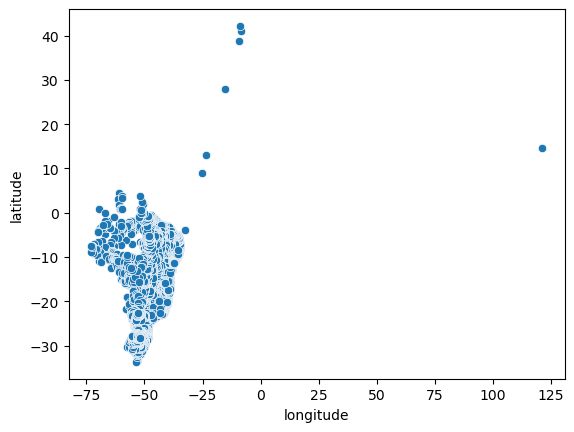

In [98]:
sns.scatterplot(ceps, x='longitude', y='latitude')

In [99]:
ceps = ceps.drop(index = ceps.loc[ceps.longitude > -26].index).reset_index(drop=True)

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

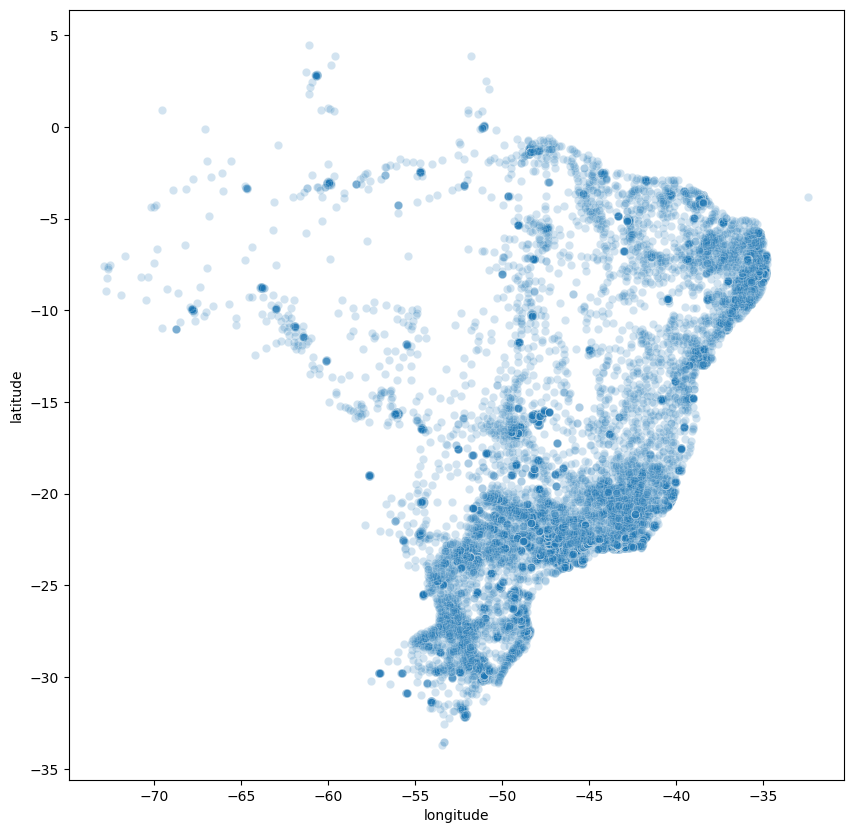

In [100]:
plt.figure(figsize=(10,10))
sns.scatterplot(ceps, x='longitude', y='latitude', alpha=0.2)

In [101]:
produto = produto.drop(columns=['product_name_lenght','product_description_lenght','product_photos_qty'])
cliente = cliente.rename(columns={'customer_zip_code_prefix':'geolocation_zip_code_prefix'})


In [102]:
cliente.shape

(99441, 5)

In [103]:
df1 = cliente.merge(ceps, how='left', on='geolocation_zip_code_prefix')
df1

,customer_id,customer_unique_id,geolocation_zip_code_prefix,customer_city,customer_state,geolocation_city,geolocation_state,latitude,longitude
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,franca,SP,-20.502070,-47.396822
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,sao bernardo do campo,SP,-23.727299,-46.542631
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,sao paulo,SP,-23.531294,-46.656404
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,mogi das cruzes,SP,-23.497390,-46.182342
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,campinas,SP,-22.973309,-47.141530
...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,sao paulo,SP,-23.585921,-46.499755
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,taboao da serra,SP,-23.615085,-46.766986
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fortaleza,CE,-3.733993,-38.510418
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,canoas,RS,-29.949632,-51.169247


In [104]:
df1 = df1.drop(columns=['geolocation_city','geolocation_state'])
df1.drop_duplicates()

,customer_id,customer_unique_id,geolocation_zip_code_prefix,customer_city,customer_state,latitude,longitude
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.502070,-47.396822
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727299,-46.542631
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531294,-46.656404
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.497390,-46.182342
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.973309,-47.141530
...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.585921,-46.499755
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.615085,-46.766986
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.733993,-38.510418
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.949632,-51.169247


In [105]:
df1 = df1.rename(columns={'latitude':'customer_lat','longitude':'customer_lon'})

In [106]:
df1

,customer_id,customer_unique_id,geolocation_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lon
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.502070,-47.396822
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727299,-46.542631
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531294,-46.656404
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.497390,-46.182342
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.973309,-47.141530
...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,-23.585921,-46.499755
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,-23.615085,-46.766986
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.733993,-38.510418
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.949632,-51.169247


In [107]:
df2  = seller.rename(columns={'seller_zip_code_prefix':'geolocation_zip_code_prefix'}).merge(ceps, how='left', on='geolocation_zip_code_prefix')
df2 = df2.rename(columns={'latitude':'seller_lat','longitude':'seller_lon'})
df2

,seller_id,geolocation_zip_code_prefix,seller_city,seller_state,geolocation_city,geolocation_state,seller_lat,seller_lon
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,campinas,SP,-22.894561,-47.062380
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,mogi guacu,SP,-22.382440,-46.947605
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,rio de janeiro,RJ,-22.909624,-43.176774
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,sao paulo,SP,-23.657453,-46.612406
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,braganca paulista,SP,-22.964436,-46.535090
...,...,...,...,...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR,sarandi,PR,-23.448778,-51.869229
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC,palhoca,SC,-27.626457,-48.673749
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP,sao paulo,SP,-23.657838,-46.677462
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,pelotas,RS,-31.751451,-52.323899


In [108]:
order = order[['order_id','customer_id']]

In [109]:
frete_seller = frete.merge(df2, how='left', on='seller_id').rename(columns={'geolocation_zip_code_prefix':'geolocation_zip_code_prefix_seller'})
frete_seller.drop_duplicates()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,geolocation_zip_code_prefix_seller,seller_city,seller_state,geolocation_city,geolocation_state,seller_lat,seller_lon
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,volta redonda,SP,volta redonda,RJ,-22.498419,-44.125272
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,3471,sao paulo,SP,sao paulo,SP,-23.564289,-46.519045
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,37564,borda da mata,MG,borda da mata,MG,-22.271648,-46.165556
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,14403,franca,SP,franca,SP,-20.554951,-47.387691
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,87900,loanda,PR,loanda,PR,-22.930408,-53.136438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,88303,itajai,SC,itajai,SC,-26.912616,-48.674015
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,1206,sao paulo,SP,sao paulo,SP,-23.536609,-46.642445
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,80610,curitiba,PR,curitiba,PR,-25.469632,-49.291261
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,4733,sao paulo,SP,sao paulo,SP,-23.636321,-46.694586


In [110]:
frete_consolidado = frete_seller.merge(order, how='left', on='order_id').merge(df1, how='left', on='customer_id').merge(produto, how='left', on='product_id')

In [111]:
frete_consolidado.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'geolocation_zip_code_prefix_seller', 'seller_city', 'seller_state',
       'geolocation_city', 'geolocation_state', 'seller_lat', 'seller_lon',
       'customer_id', 'customer_unique_id', 'geolocation_zip_code_prefix',
       'customer_city', 'customer_state', 'customer_lat', 'customer_lon',
       'product_category_name', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm'],
      dtype='object')

In [112]:
colunas_drop = ['order_id', 'order_item_id', 'product_id', 'seller_id','shipping_limit_date','geolocation_zip_code_prefix_seller','geolocation_city', 'geolocation_state', 'customer_id', 'customer_unique_id','geolocation_zip_code_prefix']
frete_consolidado = frete_consolidado.drop(columns=colunas_drop)
frete_consolidado

,price,freight_value,seller_city,seller_state,seller_lat,seller_lon,customer_city,customer_state,customer_lat,customer_lon,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,58.90,13.29,volta redonda,SP,-22.498419,-44.125272,campos dos goytacazes,RJ,-21.762829,-41.310605,cool_stuff,650.0,28.0,9.0,14.0
1,239.90,19.93,sao paulo,SP,-23.564289,-46.519045,santa fe do sul,SP,-20.205737,-50.926924,pet_shop,30000.0,50.0,30.0,40.0
2,199.00,17.87,borda da mata,MG,-22.271648,-46.165556,para de minas,MG,-19.870383,-44.594355,moveis_decoracao,3050.0,33.0,13.0,33.0
3,12.99,12.79,franca,SP,-20.554951,-47.387691,atibaia,SP,-23.104346,-46.595589,perfumaria,200.0,16.0,10.0,15.0
4,199.90,18.14,loanda,PR,-22.930408,-53.136438,varzea paulista,SP,-23.245512,-46.825182,ferramentas_jardim,3750.0,35.0,40.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,299.99,43.41,itajai,SC,-26.912616,-48.674015,sao luis,MA,-2.493458,-44.302009,utilidades_domesticas,10150.0,89.0,15.0,40.0
112646,350.00,36.53,sao paulo,SP,-23.536609,-46.642445,curitiba,PR,-25.544585,-49.303527,informatica_acessorios,8950.0,45.0,26.0,38.0
112647,99.90,16.95,curitiba,PR,-25.469632,-49.291261,sao paulo,SP,-23.598430,-46.642119,esporte_lazer,967.0,21.0,24.0,19.0
112648,55.99,8.72,sao paulo,SP,-23.636321,-46.694586,vinhedo,SP,-23.037764,-46.978860,informatica_acessorios,100.0,20.0,20.0,20.0


In [113]:
frete_alterado = frete_consolidado.copy()

In [114]:
#distancia euclidiana entre os pontos de compra e venda
frete_alterado['distancia_seller_customer'] = np.sqrt((frete_alterado.customer_lat - frete_alterado.seller_lat)**2 + (frete_alterado.customer_lon - frete_alterado.seller_lon)**2)

In [115]:
#volume do produto
frete_alterado['volume'] = frete_alterado['product_length_cm'] * frete_alterado['product_height_cm'] * frete_alterado['product_width_cm']

In [116]:
frete_alterado

,price,freight_value,seller_city,seller_state,seller_lat,seller_lon,customer_city,customer_state,customer_lat,customer_lon,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,distancia_seller_customer,volume
0,58.90,13.29,volta redonda,SP,-22.498419,-44.125272,campos dos goytacazes,RJ,-21.762829,-41.310605,cool_stuff,650.0,28.0,9.0,14.0,2.909199,3528.0
1,239.90,19.93,sao paulo,SP,-23.564289,-46.519045,santa fe do sul,SP,-20.205737,-50.926924,pet_shop,30000.0,50.0,30.0,40.0,5.541594,60000.0
2,199.00,17.87,borda da mata,MG,-22.271648,-46.165556,para de minas,MG,-19.870383,-44.594355,moveis_decoracao,3050.0,33.0,13.0,33.0,2.869625,14157.0
3,12.99,12.79,franca,SP,-20.554951,-47.387691,atibaia,SP,-23.104346,-46.595589,perfumaria,200.0,16.0,10.0,15.0,2.669614,2400.0
4,199.90,18.14,loanda,PR,-22.930408,-53.136438,varzea paulista,SP,-23.245512,-46.825182,ferramentas_jardim,3750.0,35.0,40.0,30.0,6.319117,42000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,299.99,43.41,itajai,SC,-26.912616,-48.674015,sao luis,MA,-2.493458,-44.302009,utilidades_domesticas,10150.0,89.0,15.0,40.0,24.807452,53400.0
112646,350.00,36.53,sao paulo,SP,-23.536609,-46.642445,curitiba,PR,-25.544585,-49.303527,informatica_acessorios,8950.0,45.0,26.0,38.0,3.333665,44460.0
112647,99.90,16.95,curitiba,PR,-25.469632,-49.291261,sao paulo,SP,-23.598430,-46.642119,esporte_lazer,967.0,21.0,24.0,19.0,3.243355,9576.0
112648,55.99,8.72,sao paulo,SP,-23.636321,-46.694586,vinhedo,SP,-23.037764,-46.978860,informatica_acessorios,100.0,20.0,20.0,20.0,0.662633,8000.0


In [117]:
frete_alterado.isnull().sum()

price                           0
freight_value                   0
seller_city                     0
seller_state                    0
seller_lat                    253
seller_lon                    253
customer_city                   0
customer_state                  0
customer_lat                  306
customer_lon                  306
product_category_name        1603
product_weight_g               18
product_length_cm              18
product_height_cm              18
product_width_cm               18
distancia_seller_customer     558
volume                         18
dtype: int64

### Análise exploratória

In [118]:
frete_alterado.describe()

,price,freight_value,seller_lat,seller_lon,customer_lat,customer_lon,product_weight_g,product_length_cm,product_height_cm,product_width_cm,distancia_seller_customer,volume
count,112650.000000,112650.000000,112397.000000,112397.000000,112344.000000,112344.000000,112632.000000,112632.000000,112632.000000,112632.000000,112092.000000,112632.000000
mean,120.653739,19.990320,-22.798730,-47.236213,-21.237425,-46.203168,2093.672047,30.153669,16.593766,22.996546,5.538508,15243.709567
std,183.633928,15.806405,2.697050,2.340156,5.560973,4.034734,3751.596884,16.153449,13.443483,11.707268,5.357900,23418.524686
min,0.850000,0.000000,-32.074657,-67.811160,-33.690972,-72.670987,0.000000,7.000000,2.000000,6.000000,0.000000,168.000000
25%,39.900000,13.080000,-23.607598,-48.829768,-23.590926,-48.109214,300.000000,18.000000,8.000000,15.000000,1.717692,2851.500000
50%,74.990000,16.260000,-23.424399,-46.744111,-22.930157,-46.634857,700.000000,25.000000,13.000000,20.000000,4.066896,6480.000000
75%,134.900000,21.150000,-21.757690,-46.519045,-20.182699,-43.635422,1800.000000,38.000000,20.000000,30.000000,7.383044,18375.000000
max,6735.000000,409.680000,-2.498944,-34.855123,3.844931,-34.799347,40425.000000,105.000000,105.000000,118.000000,33.818934,296208.000000


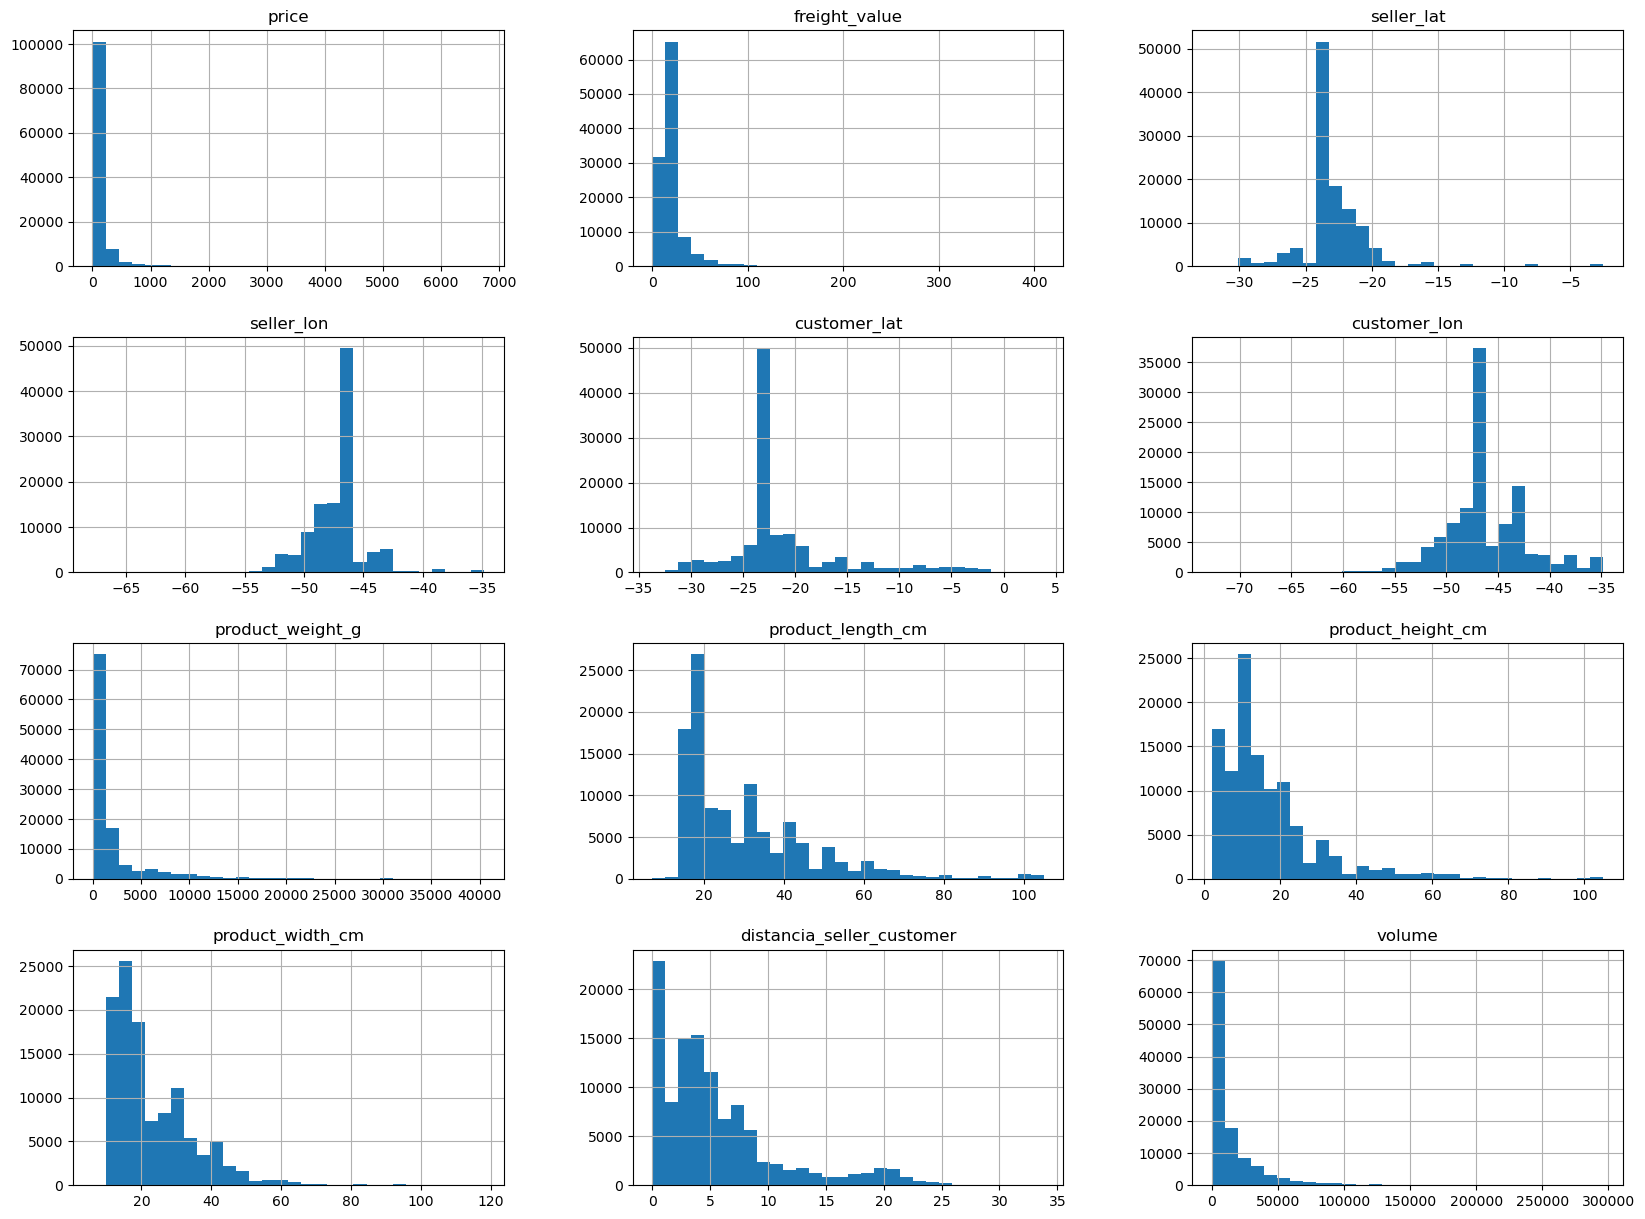

In [119]:
frete_alterado.hist(bins=30,figsize=(20,15))
plt.show()

In [120]:
frete_alterado.corr().freight_value

price                        0.414204
freight_value                1.000000
seller_lat                   0.038441
seller_lon                  -0.004468
customer_lat                 0.273236
customer_lon                 0.093084
product_weight_g             0.610420
product_length_cm            0.309086
product_height_cm            0.391831
product_width_cm             0.323777
distancia_seller_customer    0.390426
volume                       0.587270
Name: freight_value, dtype: float64

Podemos perceber que as variáveis criadas de distancia e volume possuem uma correlação signicantemente maior com a variável target.

<AxesSubplot: >

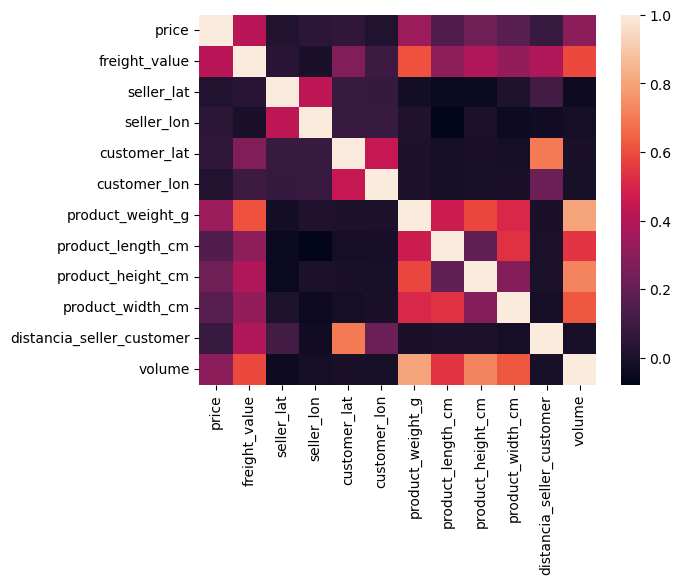

In [121]:
sns.heatmap(frete_alterado.corr())

Text(0.5, 1.0, 'Categorias mais vendidas')

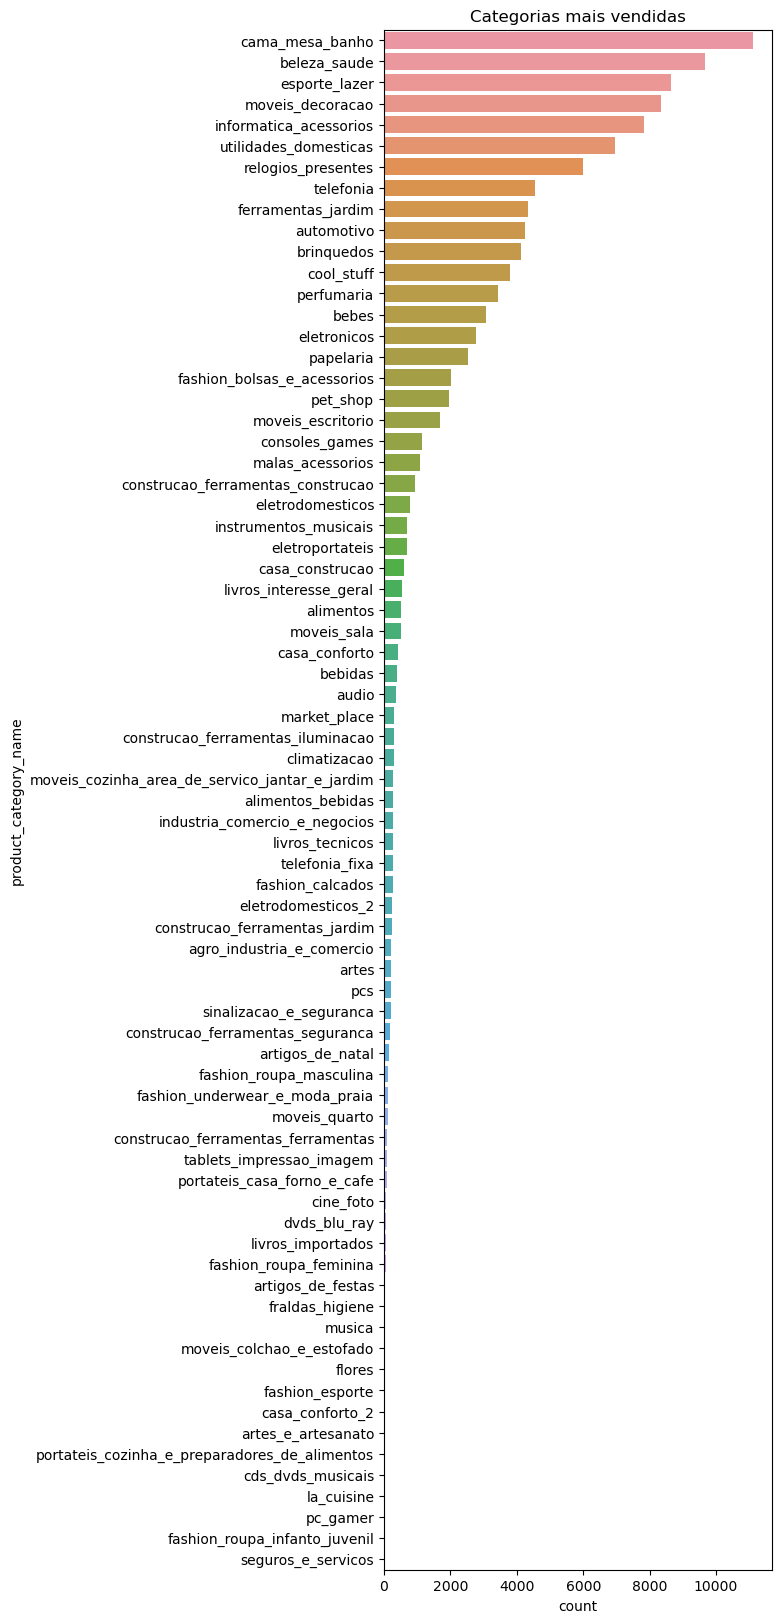

In [122]:
plt.figure(figsize=(5,20))
contagem = frete_alterado.product_category_name.value_counts().sort_values(ascending=False)
sns.countplot(frete_alterado, y='product_category_name', order=contagem.index)
plt.title('Categorias mais vendidas')

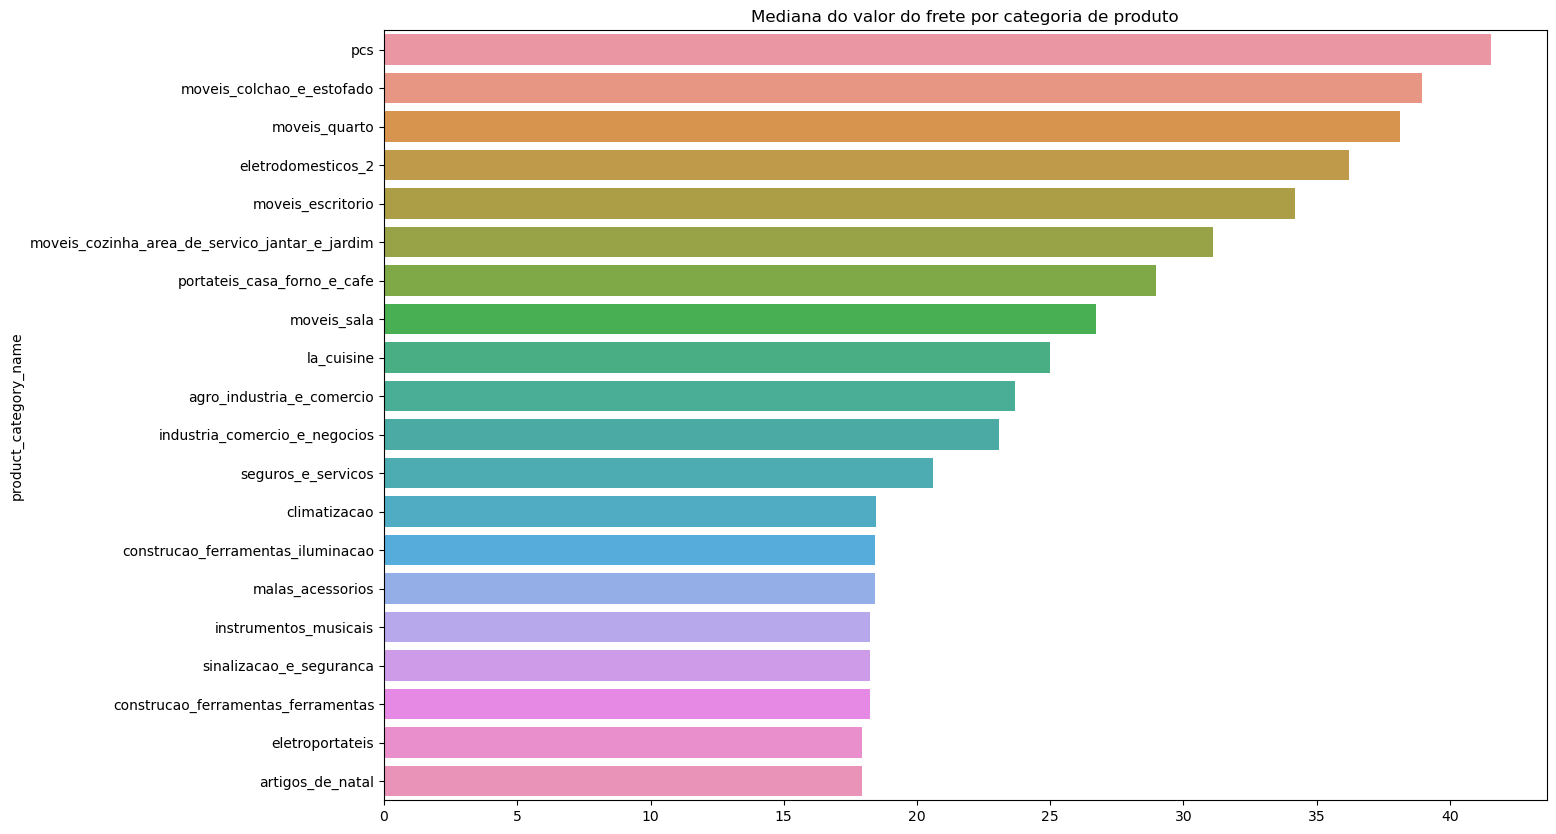

In [123]:
plt.figure(figsize=(15,10))
categorias = frete_alterado.groupby('product_category_name').freight_value.median().sort_values(ascending=False)
sns.barplot(y=categorias[:20].index, x=categorias[:20].values)
plt.title("Mediana do valor do frete por categoria de produto")
plt.show()

Text(0.5, 1.0, 'Mediana do valor do frete por estado')

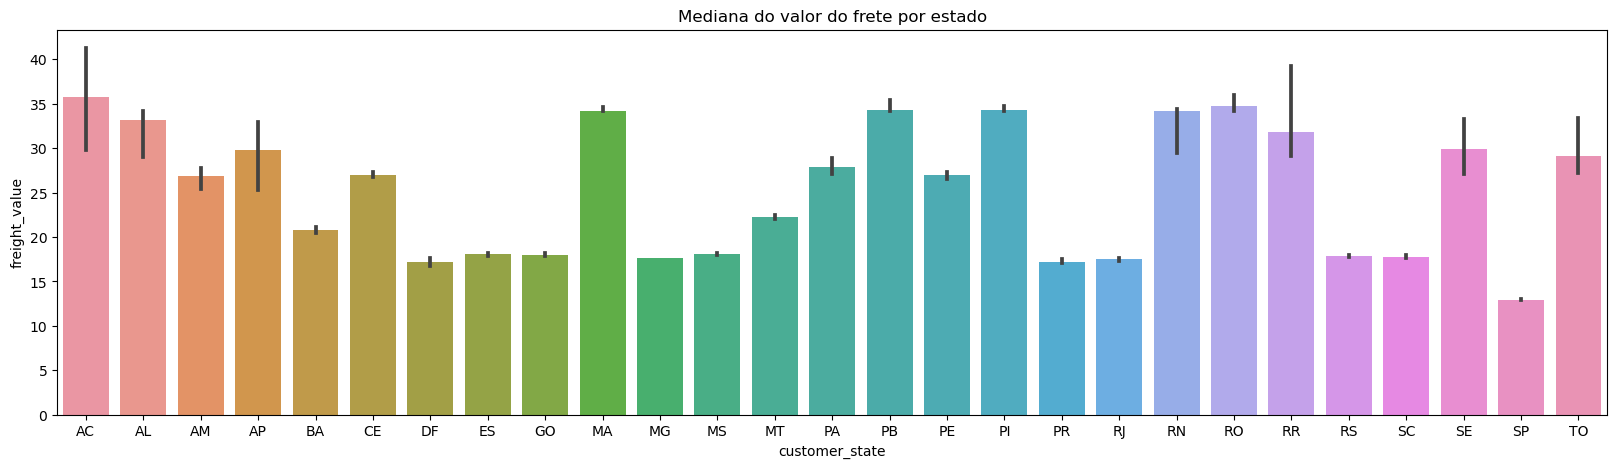

In [124]:
plt.figure(figsize=(20,5))
estados = frete_alterado.customer_state.value_counts().sort_index().index
sns.barplot(frete_alterado, x='customer_state',y='freight_value', order=estados, estimator='median')
plt.title('Mediana do valor do frete por estado')

Text(0.5, 1.0, 'Valor do frete por peso do produto em gramas')

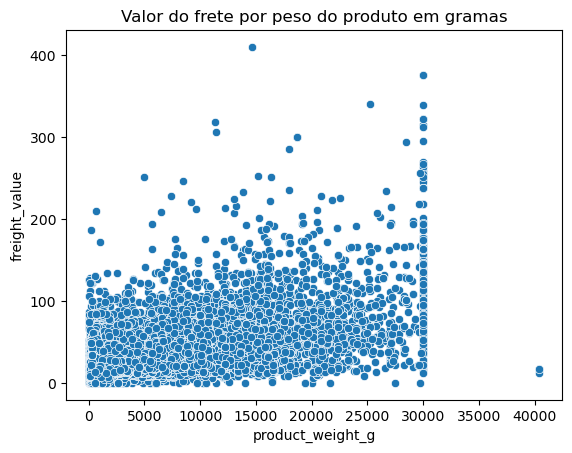

In [125]:
sns.scatterplot(frete_alterado, x='product_weight_g', y='freight_value')
plt.title('Valor do frete por peso do produto em gramas')

Text(0.5, 1.0, 'Valor do frete por volume do produto em cm³')

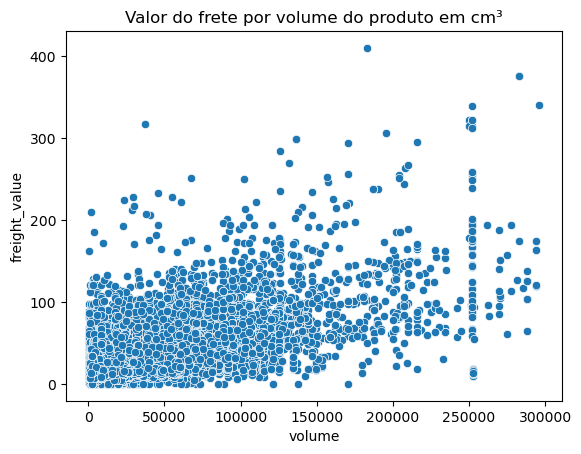

In [126]:
sns.scatterplot(frete_alterado, x='volume', y='freight_value')
plt.title('Valor do frete por volume do produto em cm³')

### Tratamento de dados e pré-processamento

#### Os seguintes tratamentos devem ser levados em conta para a criação do pipeline:
- #### Imputação de valores missing (Single Imputer)
- #### Transformação de variável categórica em numérica (One-Hot Encoder)
- #### Mudança de escala (Standard Scaler)
- #### Redução de dimensionalidade e criação de variáveis combinadas


#### Primeiramente, devemos separar os dados em dados de treino e de teste, para que não ocorra o chamado data leakage, isto é, dados do teste sendo usados para o treinamento do modelo.

In [127]:
X = frete_consolidado.drop(columns=['freight_value','seller_city','seller_state','customer_city'], axis=1) # features
y = frete_consolidado['freight_value'].copy() # target

In [128]:
from sklearn.model_selection import train_test_split

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

print(len(X_train), len(X_test), len(y_train), len(y_test))

90120 22530 90120 22530


In [130]:
X_train.isnull().sum()

price                       0
seller_lat                201
seller_lon                201
customer_state              0
customer_lat              254
customer_lon              254
product_category_name    1274
product_weight_g           17
product_length_cm          17
product_height_cm          17
product_width_cm           17
dtype: int64

In [131]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

In [132]:
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_train_cat = X_train.select_dtypes(include='object')

In [133]:
from sklearn.pipeline import make_pipeline

def num_pipeline():
    return  make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
        )

def cat_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore", sparse=False)
        )

Até agora, lidamos com as colunas categóricas e numéricas separadamente. Seria mais conveniente ter um único transformador capaz de lidar com todas as colunas, aplicando as transformações apropriadas a cada coluna. Para isso, você pode usar um ColumnTransformer. Por exemplo, o seguinte ColumnTransformer aplicará o num_pipeline (o que acabamos de definir) aos atributos numéricos e o cat_pipeline ao atributo categórico.

In [134]:
#Criando função para a distancia euclidiana

def eu_distance(X):
    return np.sqrt((X[:, [0]] - X[:, [1]])**2 + (X[:, [2]] - X[:, [3]])**2)
    # 0 - customer_lat
    # 1 - seller_lat
    # 2 - customer_lon
    # 3 - seller_lon

def distance_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(eu_distance),
        StandardScaler())

In [135]:
#Criando função para o volume do pacote

def volume(X):
    return X[:, [0]] * X[:, [1]] * X[:, [2]]

def volume_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(volume),
        StandardScaler())

In [136]:
from sklearn.compose import ColumnTransformer, make_column_selector

preprocessing = ColumnTransformer([    #Necessita nomear as etapas
    ('num', num_pipeline(), make_column_selector(dtype_include=[np.number])),
    ('cat', cat_pipeline(), make_column_selector(dtype_include=object)),
    ('distance', distance_pipeline(), ['customer_lat','seller_lat','customer_lon','seller_lon']),
    ('volume', volume_pipeline(), ['product_length_cm','product_height_cm','product_width_cm'])
])

In [137]:
frete_preprocessado = preprocessing.fit_transform(X_train)
frete_preprocessado.shape

(90120, 111)

### Criando o modelo de machine learning

In [138]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor


In [139]:
# Modelos a serem testados:

models = {'dummy': DummyRegressor(),
          'linear_regression': LinearRegression(),
          'random_forest': RandomForestRegressor(random_state=42)}

In [140]:
models.items()

dict_items([('dummy', DummyRegressor()), ('linear_regression', LinearRegression()), ('random_forest', RandomForestRegressor(random_state=42))])

In [141]:
desc = pd.DataFrame()

for name, model in models.items():
    modelo = make_pipeline(preprocessing, model)
    modelo.fit(X_train, y_train)
    
    cross_val_lr = -cross_val_score(modelo, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

    desc = pd.concat([desc, pd.Series(cross_val_lr).describe()], axis=1)

desc


,0,0,0
count,10.000000,10.000000,10.000000
mean,15.819935,9.905226,7.644853
std,0.735107,0.544367,0.514366
min,14.814613,9.203270,6.813144
25%,15.461987,9.508846,7.409761
50%,15.714864,9.806085,7.506574
75%,16.193521,10.226553,8.078340
max,17.205669,10.921315,8.315065


O modelo dummy serve como referência para outros modelos, caso o erro do modelo estudado seja superior ao do modelo dummy, ele passa a ser descartado.

In [148]:
desc.columns = ['dummy','linear regression','random forest']

In [149]:
desc

,dummy,linear regression,random forest
count,10.000000,10.000000,10.000000
mean,15.819935,9.905226,7.644853
std,0.735107,0.544367,0.514366
min,14.814613,9.203270,6.813144
25%,15.461987,9.508846,7.409761
50%,15.714864,9.806085,7.506574
75%,16.193521,10.226553,8.078340
max,17.205669,10.921315,8.315065
